In [ ]:
!pip install control


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 17.0 MB/s eta 0:00:00


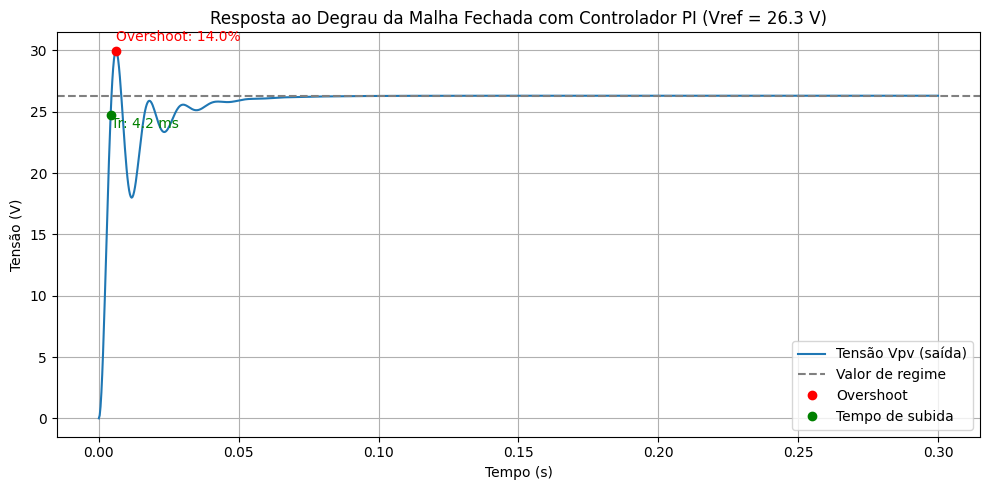

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# ===============================
# ETAPA 1: Parâmetros do sistema
# ===============================
Vmp = 26.3     # Tensão no ponto de máxima potência do painel (V)
Voc = 32.9     # Tensão de circuito aberto (V)
Imp = 7.61     # Corrente no ponto de máxima potência (A)
Cpv = 1000e-6  # Capacitância de entrada do boost (F)
Lpv = 10e-3    # Indutância do boost (H)
Vdc = 80       # Tensão do barramento DC (V)

# ===============================
# ETAPA 2: Parâmetros do modelo fotovoltaico
# ===============================
Io = 9.825e-08
a = 1.3
k = 1.3806503e-23
T = 298.15
q = 1.60217646e-19
Vt = k * T / q
Rp = 415.405
Rs = 0.221
Ns = 54

# ===============================
# ETAPA 3: Cálculo da resistência equivalente (Req)
# ===============================
expoente = (Vmp + Imp * Rs) / (a * Ns * Vt)
g = (-Io / (a * Ns * Vt)) * np.exp(expoente) - 1 / Rp
Req = -1 / g  # resistência equivalente do modelo linearizado

# ===============================
# ETAPA 4: Função de transferência da planta (conversor Boost)
# ===============================
numerator = [Vdc / (Lpv * Cpv)]
denominator = [1, 1 / (Req * Cpv), 1 / (Lpv * Cpv)]
Hp = ctrl.tf(numerator, denominator)

# ===============================
# ETAPA 5: Parâmetros de projeto do controlador PI
# ===============================
fc = 80       # frequência de cruzamento (Hz)
PM = 35       # margem de fase desejada (graus)
wc = 2 * np.pi * fc  # frequência angular (rad/s)

# Avaliação da planta na frequência de cruzamento
Hpw = (Vdc / (Lpv * Cpv)) / (-wc**2 + 1j * wc / (Req * Cpv) + 1 / (Lpv * Cpv))
Gp = abs(Hpw)
Pp = np.angle(Hpw, deg=True)

# ===============================
# ETAPA 6: Projeto do controlador PI
# ===============================
def proportional_integral_controller(wc, Pp, PM, Gp, Hpwm=1, Hs=1):
    phi = (-90 - Pp + PM) * np.pi / 180
    ki_kp = wc / np.tan(phi)
    kp = (1 / (Gp * Hpwm * Hs)) * np.sqrt(np.tan(phi)**2 / (np.tan(phi)**2 + 1))
    return kp * ctrl.tf([1, ki_kp], [1, 0])

Hpi = proportional_integral_controller(wc, Pp, PM, Gp)

# ===============================
# ETAPA 7: Malha fechada com feedback e Vref fixo (MPPT tensão fixa)
# ===============================
Vref = 26.3  # tensão de referência (fixa, como num MPPT simples)
open_loop = Hpi * Hp
closed_loop = ctrl.feedback(open_loop, 1)  # unidade de feedback

# ===============================
# ETAPA 8: Simulação da resposta ao degrau
# ===============================
t = np.linspace(0, 0.3, 1000)
t_step, y_step = ctrl.step_response(closed_loop * Vref, t)

# ===============================
# ETAPA 9: Destaques gráficos (overshoot, tempo de subida etc.)
# ===============================
y_final = y_step[-1]
overshoot = (np.max(y_step) - y_final) / y_final * 100
t_rise_idx = np.where(y_step >= 0.9 * y_final)[0][0]
t_rise = t_step[t_rise_idx]

plt.figure(figsize=(10, 5))
plt.plot(t_step, y_step, label='Tensão Vpv (saída)')
plt.axhline(y_final, color='gray', linestyle='--', label='Valor de regime')
plt.plot(t_step[np.argmax(y_step)], np.max(y_step), 'ro', label='Overshoot')
plt.plot(t_rise, y_step[t_rise_idx], 'go', label='Tempo de subida')

plt.text(t_step[np.argmax(y_step)], np.max(y_step)+0.8, f'Overshoot: {overshoot:.1f}%', color='red')
plt.text(t_rise, y_step[t_rise_idx]-1, f'Tr: {t_rise*1000:.1f} ms', color='green')

plt.xlabel('Tempo (s)')
plt.ylabel('Tensão (V)')
plt.title('Resposta ao Degrau da Malha Fechada com Controlador PI (Vref = 26.3 V)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
